# Lodieu et. al.

Herein, we consume the files from *A 5D view of the $\alpha$Per, Pleiades, and Praesepe clusters*, N. Lodieu, A. P´erez-Garrido3, R. L. Smart, and R. Silvotti. Bibcode [2019A&A...628A..66L](https://ui.adsabs.harvard.edu/#abs/2019A&A...628A..66L/abstract)

The paper mentions that data files used are available via [Vizier](https://vizier.u-strasbg.fr/viz-bin/VizieR), indeed they are; (https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/628/A66&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa) and [download](https://cdsarc.unistra.fr/viz-bin/cat/J/A%2bA/628/A66).

From the download link, the 'download all tables in tar.gz' produced a tar ball `J_A+A_628_A66.tar.gz` which is in the `data` folder. This tarball contains a Readme and three gzip'd files corresponding to the three clusters in the paper.

We'll read these file and create pickles from them for subsequent use.

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import re


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

## Parse the Readme file

THe readme file provides the layout of the data files, particularly the column names and their desctiptions

In [0]:
readme_path = './gdrive/My Drive/cas-tau/data/J_A+A_628_A66/ReadMe'
with open(readme_path,'r') as f:
    readme_txt = f.readlines()
# alpha_per and pleiades description between lines 85 and 357
#praesepe between 363 and 641 # doesn't matter, data file is corrupt
desc_dict = {'alpha_per': readme_txt[84:356],
             'praesepe':readme_txt[362:641]}

### Fix up line continuation

In [0]:
desc_dict['alpha_per'][0:5]

['    1-  10  F10.7 deg      RAdeg        Right ascension (ICRS) at epoch 2015.5\n',
 '                                         (RA_sexa)\n',
 '   12-  22  F11.7 deg      DEdeg        Declination (ICRS) at epoch 2015.5\n',
 '                                         (dec_sexa)\n',
 '   25-  43  I19   ---      SourceCP     Gaia DR2 source_id (SOURCE_ID_CP)\n']

In [0]:
desc_dict['alpha_per'][-5:]

[' 1487-1491  F5.3  Msun     Masscomb     Combined mass (Mass_combined*Myr) (G2)\n',
 ' 1493-1501  F9.6  [Msun]   logMasscomb  log of combined mass\n',
 '                                         (logMass_combined*Myr) (G2)\n',
 ' 1503-1511  F9.6  ---      RUWE         Gaia DR2 Re-normalised Unit Weight Error\n',
 '                                         (ruwe)\n']

In [0]:
desc_dict['praesepe'][0:5]

['    1-   2  I2    h        RAh          Right ascension (ICRS) at epoch 2015.5\n',
 '         3  A1    ---      ---          [:]\n',
 '    4-   5  I2    min      RAm          Right ascension (ICRS) at epoch 2015.5\n',
 '         6  A1    ---      ---          [:]\n',
 '    7-  11  F5.2  s        RAs          Right ascension (ICRS) at epoch 2015.5\n']

In [0]:
desc_dict['praesepe'][-5:]

[' 1487-1491  F5.3  Msun     Masscomb     Combined mass (Mass_combined*Myr) (G2)\n',
 ' 1493-1501  F9.6  [Msun]   logMasscomb  log of combined mass\n',
 '                                         (logMass_combined*Myr) (G2)\n',
 ' 1503-1511  F9.6  ---      RUWE         Gaia DR2 Re-normalised Unit Weight Error\n',
 '                                         (ruwe)\n']

In [0]:
def paste_cont(readme):
  """
  flattens continued lines into single line
  """
  #continuation lines have at least 40 blanks at start
  contline = r'^\ {40}.*'

  outlist =[]
  i = 0
  totlines = len(readme)
  while i < totlines:
    str = readme[i][:-1] #ditch last character which is a newline
    # look ahead to see if next lines are continuations
    while i < totlines-1 and re.match(contline,readme[i+1]):
      i = i+1
      str = str+ ' ' + readme[i].strip()
    outlist.append(str[18:]) #just need units, name and description
    i=i+1

  return outlist

In [0]:
zz=paste_cont(desc_dict['alpha_per'])

In [0]:
zz[0:5]

['deg      RAdeg        Right ascension (ICRS) at epoch 2015.5 (RA_sexa)',
 'deg      DEdeg        Declination (ICRS) at epoch 2015.5 (dec_sexa)',
 '---      SourceCP     Gaia DR2 source_id (SOURCE_ID_CP)',
 'km/s     RVCP         ?=-9999 Radial velocity (RV_CP)',
 'km/s   e_RVCP         ?=-9999 Radial velocity error (eRV_CP)']

### Dictionary from Field Descriptions

The three files in the download archive are described in the Readme file. The data files for the Pleiades and Alpha Persei share a common layout captured in the first chunk (lines 84-356) and Praesep in the second chunk lines 362 -641

The code below creates two ordered dicts, each with the units and description of each field, keyed by the field name.

Order is important, thus the need for OrderedDict so that the dictionary keys can be used to name the columns when later we read in the data files into Pandas dataframes.

Note: the Praesepe data file and its description seemed to have some problems.  Praesepe is not relevant to the current study so we'll save the resolution of these for much later.

In [0]:
from collections import OrderedDict

In [0]:

rec=lambda strlist:(strlist[0],strlist[1], ' '.join(strlist[2:])) #units, columnname and description

col_dict = {}
for c in ['alpha_per']:
  #fix up the line continuation
  dict_strings = paste_cont(desc_dict[c])

  dict_df = pd.DataFrame([rec(s.split()) for s in dict_strings], columns=['units','ColumnName','desc'])
  dict_df.set_index('ColumnName', inplace=True)

  # turn the data frame into the ordered dict
  col_dict[c]= dict_df.to_dict(into=OrderedDict,orient='index')

In [0]:
col_dict['alpha_per']['rest']

{'desc': 'Estimated distance (r_est)', 'units': 'pc'}

### Save the pickled column definition file

In [0]:
import pickle

In [0]:
colnames_txt_path = './gdrive/My Drive/cas-tau/data/J_A+A_628_A66/alpha_per_definition.pkl'
with open(colnames_txt_path,'wb') as pkl:
  pickle.dump(col_dict['alpha_per'],pkl)

## Read the data files
As mentioned earlier, the data file for the Praesepe cluster is corrupt upon download, so we'll read on the data files for Alpha Persei and Plieades. These files have their problems too, namely inconsistant formatting out to the right. Not to worry though, as the Gaia data we're interested in (for now) is to the left side and can be easily read into a pandas data frame.

First we'll re-read the pickled column definition file to verify its usefulness.

In [0]:
colnames_txt_path = './gdrive/My Drive/cas-tau/data/J_A+A_628_A66/alpha_per_definition.pkl'
with open(colnames_txt_path,'rb') as pkl:
  alpha_per_coldefs = pickle.load(pkl)

In [0]:
alpha_per_coldefs['rest']['desc']

'Estimated distance (r_est)'

The Gaia data occupies the leftmost columns in the datafiles; the last column is called `ModFlag`, so we need all columns up and including `ModFlag`

In [0]:
import os

lastcol = tuple(alpha_per_coldefs.keys()).index('ModFlag')+1
root_dir = './gdrive/My Drive/cas-tau/data/J_A+A_628_A66'

data_files = {}
for c in ['alphaper', 'pleiades']:
  path = os.path.join(root_dir,c+'.dat')
  data_files[c] = pd.read_csv(path, delim_whitespace=True, error_bad_lines=False, warn_bad_lines=True,
                        header=None,usecols=range(lastcol), names=list(alpha_per_coldefs.keys())[0:lastcol])

In [0]:
data_files['alphaper'].head()

,RAdeg,DEdeg,SourceCP,RVCP,e_RVCP,PlxCP,e_PlxCP,GmagCP,pmRACP,e_pmRACP,pmDECP,e_pmDECP,bx,by,bz,vx,vy,vz,c,distC,Source,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,RADEcor,RAPlxcor,RApmRAcor,RApmDEcor,DEPlxcor,DEpmRAcor,DEpmDEcor,PlxpmRAcor,PlxpmDEcor,pmRApmDEcor,NAL,NAC,NgAL,...,chi2AL,epsi,sepsi,Solved,APF,WAL,pscol,e_pscol,fvarpi,MatchObsA,Nper,amax,MatchObs,Dup,o_Gmag,FG,e_FG,RFG,Gmag,o_BPmag,FBP,e_FBP,RFBP,BPmag,o_RPmag,FRP,e_FRP,RFRP,RPmag,E(BR/RP),Mode,RV,e_RV,o_RV,rest,b_rest,B_rest,rlen,ResFlag,ModFlag
0,34.813290,52.493074,455075360092433920,-9999.0,-9999.0,5.77091,0.109942,16.5334,27.646,0.350,-19.901,0.181,-123.872,118.688,-24.409,-9999.0,-9999.0,-9999.0,0.420957,34.5058,455075360092433920,5.7999,0.1099,27.646,0.350,-19.901,0.181,-0.2699,-0.5139,-0.8077,0.4042,0.0562,0.3804,-0.1491,0.5416,-0.1116,-0.3220,141,0,141,...,207.98,0.281,2.61,31,0,3.4993,1.2448,0.0191,-0.114,16,10,0.339762,19,0,166,4592.00,4.7807,960.526,16.5334,15,615.380,10.6550,57.758,18.378500,18,6480.10,18.5470,349.383,15.233000,1.545,0,0.0,0.0,0,171.669,168.464,174.996,827.580,1,1
1,35.010252,52.664085,455037048980464896,-9999.0,-9999.0,5.63410,1.095480,20.3099,18.664,2.195,-20.069,1.896,-127.060,121.507,-24.384,-9999.0,-9999.0,-9999.0,13.234600,34.3879,455037048980464896,5.6581,1.0955,18.664,2.195,-20.069,1.896,0.2736,-0.4405,-0.6056,-0.0620,-0.1343,-0.0219,0.3494,0.3507,0.3873,0.2143,115,0,113,...,123.82,1.942,2.12,31,0,0.0436,1.7967,0.2023,-0.008,14,9,2.102480,17,0,139,141.71,1.0618,133.458,20.3099,9,28.670,10.6950,2.681,21.707800,16,234.81,9.2633,25.348,18.835100,1.859,0,0.0,0.0,0,189.235,149.916,256.777,834.032,1,1
2,35.076013,52.480215,455026156947855872,-9999.0,-9999.0,5.46087,1.454370,20.3340,21.394,3.404,-2.636,2.976,-131.260,125.082,-25.662,-9999.0,-9999.0,-9999.0,12.647600,35.1074,455026156947855872,5.4758,1.4544,21.394,3.404,-2.636,2.976,0.3917,-0.0868,-0.5967,-0.1674,0.0537,-0.2249,-0.2459,0.2538,0.2781,0.2142,98,0,98,...,262.85,5.371,10.10,31,0,0.0186,1.3558,0.3260,-0.009,11,9,3.279610,15,1,125,138.59,1.3518,102.525,20.3340,11,51.996,5.1588,10.079,21.061501,14,188.02,18.8130,9.994,19.076401,1.732,0,0.0,0.0,0,211.700,126.050,725.565,828.804,1,1
3,35.095645,48.516677,355242590505237888,-9999.0,-9999.0,5.89340,0.077502,15.8404,27.676,0.134,-19.837,0.128,-122.993,111.648,-34.630,-9999.0,-9999.0,-9999.0,0.767255,33.9603,355242590505237888,5.9488,0.0775,27.676,0.134,-19.837,0.128,0.1752,0.2034,-0.5221,0.0501,-0.2183,-0.0538,-0.2104,0.0859,0.3614,0.1999,195,0,195,...,353.91,0.300,6.64,31,0,5.2357,1.2836,0.0156,-0.002,22,11,0.134695,24,0,213,8693.70,9.2816,936.664,15.8404,22,1552.200,10.2840,150.926,17.374001,22,11301.00,36.1090,312.962,14.629200,1.478,0,0.0,0.0,0,167.334,165.175,169.549,686.124,1,1
4,35.202351,49.437643,355343947436467200,-9999.0,-9999.0,5.82667,0.286555,17.6887,36.234,0.626,-24.237,0.433,-124.281,113.835,-32.416,-9999.0,-9999.0,-9999.0,19.325500,33.2344,355343947436467200,5.8477,0.2866,36.234,0.626,-24.237,0.433,-0.0121,-0.0533,-0.6749,0.1690,-0.1872,0.1828,0.0101,0.1676,0.2505,0.0145,143,0,143,...,512.20,1.149,14.90,31,0,0.4716,1.3067,0.0562,-0.038,17,10,0.575591,19,0,156,1584.40,7.5617,209.534,17.6887,13,341.910,10.0650,33.970,19.016600,12,2415.60,14.7320,163.971,16.304399,1.740,1,0.0,0.0,0,170.884,162.705,179.914,721.461,1,1


In [0]:
data_files['pleiades'].head()

,RAdeg,DEdeg,SourceCP,RVCP,e_RVCP,PlxCP,e_PlxCP,GmagCP,pmRACP,e_pmRACP,pmDECP,e_pmDECP,bx,by,bz,vx,vy,vz,c,distC,Source,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,RADEcor,RAPlxcor,RApmRAcor,RApmDEcor,DEPlxcor,DEpmRAcor,DEpmDEcor,PlxpmRAcor,PlxpmDEcor,pmRApmDEcor,NAL,NAC,NgAL,...,chi2AL,epsi,sepsi,Solved,APF,WAL,pscol,e_pscol,fvarpi,MatchObsA,Nper,amax,MatchObs,Dup,o_Gmag,FG,e_FG,RFG,Gmag,o_BPmag,FBP,e_FBP,RFBP,BPmag,o_RPmag,FRP,e_FRP,RFRP,RPmag,E(BR/RP),Mode,RV,e_RV,o_RV,rest,b_rest,B_rest,rlen,ResFlag,ModFlag
0,40.974958,22.655750,88861709418842496,-9999.0,-9999.0,6.71157,0.676616,18.172001,14.119,1.083,-30.067,0.888,-112.216,54.058,-81.763,-9999.0,-9999.0,-9999.0,18.61490,37.9345,88861709418842496,7.4218,0.6766,15.587,1.083,-33.165,0.888,-0.0970,0.2967,0.0866,0.0992,-0.4736,-0.0052,0.1898,0.0919,0.1990,0.0687,133,0,133,...,1979.09,3.389,80.700,31,0,0.0741,1.8045,0.1434,-0.062,15,9,0.958206,15,0,123,1014.80,10.22600,99.236,18.1724,15,314.460,18.1190,17.355,19.107500,15,2108.70,23.4340,89.986,16.451900,2.388,0,0.0,0.0,0,136.083,124.114,150.562,379.934,1,1
1,41.714667,22.655861,112681288804808064,-9999.0,-9999.0,8.07824,0.827281,20.066000,22.674,1.634,-54.558,1.144,-94.145,43.939,-67.304,-9999.0,-9999.0,-9999.0,17.52660,32.7146,112681288804808064,8.1425,0.8273,22.806,1.634,-54.808,1.144,0.3235,-0.2480,-0.3352,-0.0968,-0.4960,-0.2220,-0.1513,0.4171,0.3586,0.3123,113,0,113,...,128.05,1.184,0.756,31,0,0.0630,1.2171,0.1526,-0.074,13,7,1.543840,14,0,114,177.32,1.91950,92.376,20.0665,8,53.683,15.1180,3.551,21.026800,13,337.29,7.8594,42.915,18.441900,2.205,0,0.0,0.0,0,124.553,112.401,139.600,382.350,1,1
2,42.242875,27.033833,114833750319750912,-9999.0,-9999.0,8.03954,0.242093,18.396999,20.544,0.467,-32.089,0.349,-96.912,49.626,-60.142,-9999.0,-9999.0,-9999.0,21.62330,31.6872,114833750319750912,8.0638,0.2421,20.579,0.467,-32.107,0.349,0.0030,0.1371,-0.3997,0.1753,-0.2543,0.1103,0.0367,0.3089,0.1188,0.1890,115,0,114,...,134.65,0.519,1.550,31,0,0.6275,1.0771,0.0583,0.005,13,9,0.432369,13,0,113,824.94,2.17130,379.930,18.3973,12,87.930,11.6640,7.539,20.490999,11,1245.80,22.3640,55.706,17.023300,1.617,0,0.0,0.0,0,123.755,120.125,127.607,404.416,1,1
3,42.822208,28.811111,128604205745014656,-9999.0,-9999.0,7.39081,0.973410,20.045000,41.375,1.728,-65.287,1.293,-106.706,55.827,-61.678,-9999.0,-9999.0,-9999.0,8.79421,30.9459,128604205745014656,7.4174,0.9734,41.455,1.728,-65.346,1.293,0.1555,-0.1035,-0.4622,0.2204,-0.4961,0.0311,0.1747,0.3952,0.0358,0.2521,131,0,131,...,214.26,2.543,3.300,31,0,0.0457,0.8008,0.1859,-0.062,15,9,1.625480,15,0,131,180.94,1.44640,125.097,20.0445,9,48.525,7.6162,6.371,21.136499,14,302.53,7.1920,42.065,18.559999,1.940,0,0.0,0.0,0,138.362,120.680,162.030,419.403,1,1
4,42.928667,31.943389,130317932056151680,-9999.0,-9999.0,7.49413,0.913303,20.243000,30.704,1.493,-44.299,1.286,-106.068,59.397,-55.020,-9999.0,-9999.0,-9999.0,5.05662,33.5951,130317932056151680,7.5192,0.9133,30.722,1.493,-44.277,1.286,0.0428,0.3355,-0.1155,0.1409,-0.1782,0.0183,0.2173,0.2185,0.2732,0.1766,150,0,150,...,253.91,2.696,2.820,31,0,0.0337,1.4532,0.1961,-0.035,17,10,1.370500,23,0,203,150.70,0.93988,160.337,20.2431,10,30.326,5.2045,5.827,21.646799,19,317.26,10.2480,30.958,18.508400,2.307,1,0.0,0.0,0,135.951,120.013,156.701,451.484,1,1


In [0]:
len(data_files['alphaper']), len(data_files['pleiades'])

(3162, 2281)

### Pickle out the Data Files

In [0]:
root_dir = './gdrive/My Drive/cas-tau/data/J_A+A_628_A66'
for c in ['alphaper', 'pleiades']:
  path = os.path.join(root_dir,c+'.pkl')
  with open(path,'wb') as pkl:
    pickle.dump(data_files[c], pkl)


In [0]:
root_dir = './gdrive/My Drive/cas-tau/data/J_A+A_628_A66'
path = os.path.join(root_dir, 'alphaper.pkl')
with open(path,'rb') as pkl:
  alpha_per = pickle.load(pkl)

In [0]:
len(alpha_per)

3162

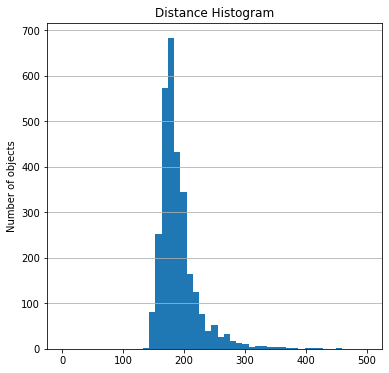

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
zz=ax.hist(alpha_per.rest,bins=np.linspace(0,500,50, endpoint=True))
ax.set_ylabel('Number of objects')
#un = clust['dist'][0].unit
#ax.set_xlabel(f'Distance ({un})')
ax.set_title('Distance Histogram')
N = len(alpha_per)
#ax.text(6000,4100,f'N = {N}')
ax.grid(axis='y')


In [0]:
zz

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,  80., 253., 573., 683., 432., 345., 165., 125.,
         77.,  40.,  53.,  25.,  32.,  18.,  13.,  11.,   4.,   6.,   7.,
          5.,   5.,   4.,   2.,   2.,   0.,   2.,   1.,   1.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.]),
 array([  0.        ,  10.20408163,  20.40816327,  30.6122449 ,
         40.81632653,  51.02040816,  61.2244898 ,  71.42857143,
         81.63265306,  91.83673469, 102.04081633, 112.24489796,
        122.44897959, 132.65306122, 142.85714286, 153.06122449,
        163.26530612, 173.46938776, 183.67346939, 193.87755102,
        204.08163265, 214.28571429, 224.48979592, 234.69387755,
        244.89795918, 255.10204082, 265.30612245, 275.51020408,
        285.71428571, 295.91836735, 306.12244898, 316.32653061,
        326.53061224, 336.73469388, 346.93877551, 357.14285714,
        367.34693878, 377.55102041, 387.75510204, 397.95918367,
        408.16326531, 41

In [0]:
zz[1][zz[0].argmax()]

173.46938775510205